In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [2]:
data = loadmat("../data/ex9data2.mat")
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [3]:
X, Xval, yval = data['X'], data['Xval'], data['yval']
print(f"X_shape: {X.shape}, Xval_shape: {Xval.shape}, yval_shape: {yval.shape}")

X_shape: (1000, 11), Xval_shape: (100, 11), yval_shape: (100, 1)


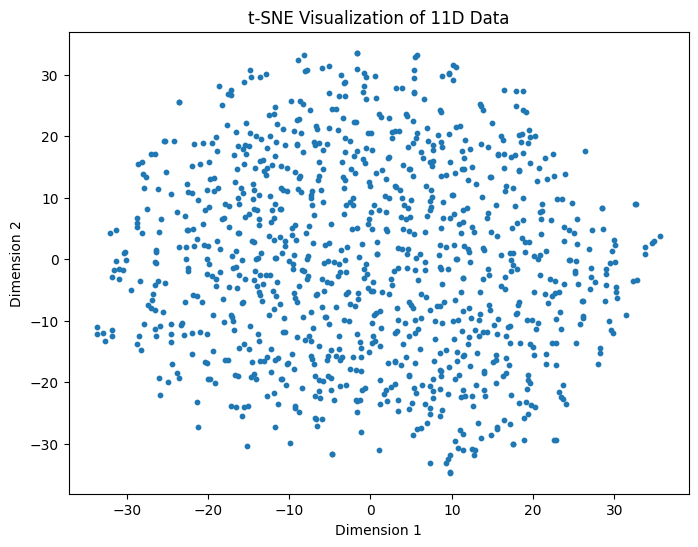

In [4]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
embedded_data = tsne.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(embedded_data[:, 0], embedded_data[:, 1], s=10)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE Visualization of 11D Data')
plt.show()

### **1. 获取训练集中样本特征的均值和方差**

In [5]:
def calculate_statistics(dataset):
    mean = np.mean(dataset, axis=0)
    variance = np.var(dataset, axis=0)
    std_deviation = np.std(dataset, axis=0)
    covariance_matrix = np.cov(dataset, rowvar=False, ddof=0)
    return mean, variance, std_deviation, covariance_matrix

mean, variance, std_deviation, covariance_matrix = calculate_statistics(X)

### **2. 概率密度函数**

In [6]:
from scipy.stats import norm
from scipy.stats import multivariate_normal

def joint_pdf(sample, mean, std_deviation):
    joint_pdf_value = 1
    for i in range(len(sample)):
        pdf_i = norm.pdf(sample[i], mean[i], std_deviation[i])
        joint_pdf_value *= pdf_i
    
    return joint_pdf_value

def multivariate_normal_pdf(sample, mean, cov):
    if np.linalg.det(cov) == 0:
        raise ValueError("The covariance matrix must be positive definite.")
    pdf_value = multivariate_normal.pdf(sample, mean, cov)
    return pdf_value

In [7]:
p = np.zeros(X.shape[0])
pval = np.zeros(Xval.shape[0])

for i in range(X.shape[0]):
    p[i] = joint_pdf(X[i], mean, std_deviation)

for i in range(Xval.shape[0]):
    pval[i] = joint_pdf(Xval[i], mean, std_deviation)

print(f"min_pval: {min(pval)}, max_pval: {max(pval)}")
cnt1, cnt0 = np.sum(yval == 1), np.sum(yval == 0)
print('Count of positive labels:', cnt1)
print('Count of negative labels:', cnt0)

yval = yval.flatten()

min_pval: 5.953349076111351e-26, max_pval: 1.3772288312874018e-15
Count of positive labels: 10
Count of negative labels: 90


### **3. 假设各个特征相互独立**

In [8]:
def select_threshold(pval, yval):
    best_epsilon = 0
    best_f1 = 0
    
    step_size = (max(pval) - min(pval)) / 1000
    epsilons = np.arange(min(pval), max(pval), step_size)
    
    for epsilon in epsilons:
        preds = pval < epsilon
        
        tp = np.sum((preds == 1) & (yval == 1))
        fp = np.sum((preds == 1) & (yval == 0))
        fn = np.sum((preds == 0) & (yval == 1))
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        if f1 > best_f1:
            best_f1 = f1
            best_epsilon = epsilon
    
    return best_epsilon, best_f1

In [9]:
epsilon, f1 = select_threshold(pval, yval)
epsilon, f1

(1.3772288907613589e-18, 0.6153846153846154)

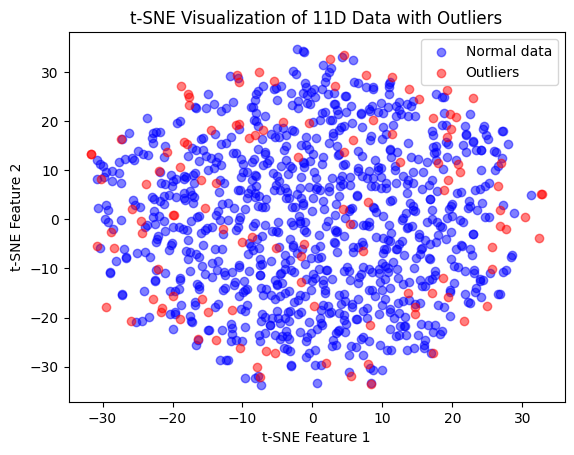

In [10]:
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X)

# 计算异常点的索引
outliers = np.where(p < epsilon)[0]
normal_data = np.where(p >= epsilon)[0]

# 绘制正常的数据点
plt.scatter(X_embedded[normal_data, 0], X_embedded[normal_data, 1], color='blue', label='Normal data', alpha=0.5)

# 绘制异常数据点
plt.scatter(X_embedded[outliers, 0], X_embedded[outliers, 1], color='red', label='Outliers', alpha=0.5)

# 添加图例
plt.legend()

# 添加轴标签
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')

# 添加标题
plt.title('t-SNE Visualization of 11D Data with Outliers')

# 显示图形
plt.show()

### **4. 采用协方差矩阵**

In [11]:
cov_p = np.zeros(X.shape[0])
cov_pval = np.zeros(Xval.shape[0])

for i in range(X.shape[0]):
    cov_p[i] = multivariate_normal_pdf(X[i], mean, covariance_matrix)

for i in range(Xval.shape[0]):
    cov_pval[i] = multivariate_normal_pdf(Xval[i], mean, covariance_matrix)

In [12]:
epsilon, f1 = select_threshold(cov_pval, yval)
epsilon, f1

(1.7538488712458804e-18, 0.5517241379310345)